In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Unzip data 

In [ ]:
!unzip /content/drive/MyDrive/ML1_Project/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/ML1_Project/AFLW2000-3D.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image0000

In [1]:
%%capture
!pip install mediapipe

### Imports

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from PIL import Image, ImageFilter

### Load Data

In [ ]:
# list to The final path component for each mat files, without its suffix
mylist_jpg =[Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")]

In [ ]:
### User-defined-function

#when read mat file which contain information of each image , we get dictionary with keys
# 'Color_Para','Exp_Para','Illum_Para','Pose_Para','Shape_Para','__globals__'
#'__header__','__version__','pt2d','pt3d_68','roi'
## get yaw, pitch, roll for each image
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params


In [ ]:
data_for_all_images=[]
name_for_all_images=[]
data_for_all_labels=[]

mp_face_mesh = mediapipe.solutions.face_mesh
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True)

for img in mylist_jpg:
  mat_path = os.path.join('/content/AFLW2000/',img + '.mat')
  image = cv2.imread(os.path.join('/content/AFLW2000/',img + '.jpg'))
  pose = get_ypr_from_mat(mat_path)
  pitch = pose[0] 
  yaw = pose[1] 
  roll = pose[2] 
  cont_labels = [yaw, pitch, roll]
  # we get landmark points (468 point) 
  results = face_mesh_images.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  landmarks_of_current_img=[]
  if results.multi_face_landmarks != None: 
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
      for i,landmark in enumerate(face.landmark):
           x = landmark.x
           y = landmark.y
           # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
           shape = image.shape 
           relative_x = int(x * shape[1])
           relative_y = int(y * shape[0])
           landmarks_of_current_img.append(relative_x)
           landmarks_of_current_img.append(relative_y)

  name_for_all_images.append(img+'.jpg')
  data_for_all_images.append(np.array(landmarks_of_current_img,dtype=np.float32))
  data_for_all_labels.append(np.array(cont_labels,dtype=np.float32))

In [ ]:
len(data_for_all_labels)

2000

In [ ]:
len(data_for_all_images[2])

0

In [ ]:
df_label=pd.DataFrame(data_for_all_labels,columns=['yaw', 'pitch', 'roll'])

In [ ]:
df = pd.DataFrame(data_for_all_images)
df[['yaw', 'pitch', 'roll']]=df_label

In [ ]:
df['img']=name_for_all_images

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,yaw,pitch,roll,img
0,209.0,298.0,211.0,273.0,214.0,280.0,216.0,246.0,213.0,266.0,...,246.0,234.0,298.0,240.0,302.0,239.0,0.286366,-0.145038,0.271484,image02346.jpg
1,243.0,296.0,251.0,270.0,242.0,279.0,239.0,247.0,251.0,262.0,...,243.0,233.0,269.0,229.0,271.0,226.0,-0.324946,0.079999,0.009769,image02867.jpg
2,251.0,282.0,264.0,249.0,254.0,264.0,254.0,227.0,266.0,241.0,...,268.0,228.0,309.0,243.0,315.0,240.0,-0.322418,0.460877,0.133306,image03652.jpg
3,217.0,317.0,226.0,290.0,222.0,296.0,224.0,257.0,228.0,281.0,...,251.0,234.0,302.0,229.0,308.0,224.0,0.019246,-0.400446,0.183995,image03654.jpg
4,195.0,282.0,188.0,258.0,200.0,270.0,202.0,241.0,190.0,252.0,...,232.0,237.0,265.0,248.0,270.0,248.0,1.071863,0.152049,0.674847,image02712.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,210.0,308.0,197.0,278.0,210.0,287.0,201.0,251.0,197.0,269.0,...,233.0,232.0,280.0,226.0,285.0,221.0,0.392902,-0.011849,0.008904,image03936.jpg
1996,225.0,310.0,224.0,280.0,225.0,288.0,217.0,247.0,224.0,270.0,...,238.0,223.0,285.0,211.0,289.0,208.0,-0.055147,-0.122574,-0.015933,image00379.jpg
1997,221.0,295.0,215.0,268.0,220.0,277.0,211.0,243.0,215.0,260.0,...,235.0,226.0,283.0,217.0,288.0,214.0,0.241326,-0.000087,-0.060991,image00937.jpg
1998,200.0,304.0,186.0,277.0,202.0,287.0,196.0,248.0,186.0,269.0,...,230.0,230.0,275.0,228.0,280.0,224.0,1.197566,-0.045438,0.031494,image02679.jpg


### Save data 

In [ ]:
df.to_csv("train_set.csv",index=False) #save to file

#Then, to reload:
df = pd.read_csv("train_set.csv")

## Build Baseline model

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split


### Data preprocessing 

In [ ]:
#Then, to reload:
df = pd.read_csv("/content/train_set.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Columns: 940 entries, 0 to img
dtypes: float64(939), object(1)
memory usage: 2.8+ MB


In [ ]:
df.shape

(388, 940)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(365, 940)

In [ ]:
#sns.histplot(x=df['z'])
pose_param=['yaw','pitch','roll']

In [ ]:
#df.describe()

In [ ]:
# normalize based on one point
landmarks=df.iloc[:,:-4]
landmarks.iloc[:,::2]=landmarks.iloc[:,::2].sub(landmarks.iloc[:,10],axis=0)
landmarks.iloc[:,1::2]=landmarks.iloc[:,1::2].sub(landmarks.iloc[:,11],axis=0)
landmarks

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-8.0,43.0,-6.0,18.0,-3.0,25.0,-1.0,-9.0,-4.0,11.0,...,39.0,-22.0,33.0,-21.0,29.0,-21.0,81.0,-15.0,85.0,-16.0
1,-6.0,43.0,2.0,17.0,-7.0,26.0,-10.0,-6.0,2.0,9.0,...,-4.0,-22.0,-6.0,-21.0,-6.0,-20.0,20.0,-24.0,22.0,-27.0
2,-14.0,49.0,-1.0,16.0,-11.0,31.0,-11.0,-6.0,1.0,8.0,...,8.0,-3.0,4.0,-4.0,3.0,-5.0,44.0,10.0,50.0,7.0
3,-13.0,48.0,-4.0,21.0,-8.0,27.0,-6.0,-12.0,-2.0,12.0,...,29.0,-41.0,24.0,-38.0,21.0,-35.0,72.0,-40.0,78.0,-45.0
4,-1.0,36.0,-8.0,12.0,4.0,24.0,6.0,-5.0,-6.0,6.0,...,45.0,-9.0,41.0,-8.0,36.0,-9.0,69.0,2.0,74.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,25.0,42.0,18.0,19.0,16.0,27.0,-17.0,-1.0,11.0,11.0,...,-24.0,-45.0,-25.0,-39.0,-24.0,-36.0,3.0,-84.0,3.0,-90.0
383,8.0,31.0,-4.0,15.0,7.0,20.0,1.0,-8.0,-4.0,8.0,...,34.0,-23.0,30.0,-22.0,27.0,-21.0,66.0,-23.0,70.0,-25.0
384,22.0,31.0,2.0,16.0,17.0,16.0,-1.0,-8.0,-1.0,10.0,...,26.0,-41.0,23.0,-38.0,20.0,-34.0,56.0,-50.0,59.0,-55.0
385,11.0,37.0,-1.0,17.0,8.0,24.0,-2.0,-8.0,-2.0,10.0,...,32.0,-29.0,27.0,-27.0,24.0,-26.0,67.0,-36.0,72.0,-38.0


In [ ]:
df.iloc[:,:-4]=landmarks

In [ ]:
corr_matrix = df.corr()
print(corr_matrix["yaw"].sort_values(ascending=False))
print(corr_matrix["pitch"].sort_values(ascending=False))
print(corr_matrix["roll"].sort_values(ascending=False))

yaw    1.000000
468    0.895516
186    0.894578
254    0.888525
264    0.887364
         ...   
90    -0.303109
550   -0.322324
8     -0.625352
10          NaN
11          NaN
Name: yaw, Length: 939, dtype: float64
pitch    1.000000
929      0.662699
931      0.658654
907      0.655745
715      0.653855
           ...   
551     -0.341281
3       -0.360916
9       -0.497486
10            NaN
11            NaN
Name: pitch, Length: 939, dtype: float64
roll    1.000000
563     0.684174
727     0.657054
20      0.649114
302     0.640557
          ...   
708    -0.812356
250    -0.823541
38     -0.830906
10           NaN
11           NaN
Name: roll, Length: 939, dtype: float64


In [ ]:
df.isna().sum().max()

0

In [ ]:
# split data three times
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df[df.drop(['img']+pose_param,axis=1).columns]= scaler.fit_transform(df.drop(['img']+pose_param,axis=1))
X_train, X_test, Y_train, Y_test = train_test_split(landmarks, 
                                                    df[pose_param], 
                                                    test_size=0.2,
                                                    random_state=0)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
311,-15.0,38.0,-6.0,20.0,-10.0,26.0,-5.0,-11.0,-3.0,11.0,...,27.0,-28.0,22.0,-27.0,20.0,-26.0,67.0,-25.0,72.0,-26.0
68,9.0,54.0,3.0,19.0,5.0,33.0,-9.0,-5.0,2.0,10.0,...,21.0,-23.0,16.0,-20.0,13.0,-19.0,64.0,-29.0,69.0,-34.0
253,1.0,45.0,-2.0,19.0,1.0,27.0,-3.0,-8.0,-2.0,11.0,...,31.0,-26.0,27.0,-24.0,23.0,-24.0,70.0,-27.0,75.0,-28.0
325,14.0,29.0,1.0,14.0,11.0,17.0,-2.0,-6.0,-1.0,8.0,...,25.0,-29.0,22.0,-26.0,19.0,-24.0,53.0,-37.0,56.0,-41.0
336,0.0,50.0,-1.0,20.0,1.0,29.0,-6.0,-8.0,-1.0,11.0,...,24.0,-29.0,19.0,-27.0,16.0,-26.0,61.0,-32.0,66.0,-34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,-11.0,48.0,-1.0,22.0,-7.0,29.0,-9.0,-11.0,0.0,12.0,...,11.0,-35.0,7.0,-33.0,6.0,-31.0,47.0,-38.0,51.0,-41.0
203,-17.0,43.0,-1.0,19.0,-15.0,25.0,-9.0,-8.0,2.0,11.0,...,-8.0,-37.0,-9.0,-34.0,-8.0,-31.0,14.0,-44.0,15.0,-47.0
125,18.0,54.0,3.0,19.0,14.0,33.0,-5.0,-2.0,0.0,10.0,...,35.0,-28.0,29.0,-24.0,24.0,-23.0,77.0,-46.0,81.0,-53.0
50,19.0,39.0,0.0,17.0,17.0,23.0,3.0,-8.0,-2.0,9.0,...,37.0,-32.0,33.0,-30.0,28.0,-27.0,64.0,-36.0,68.0,-40.0


### Modeling

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train['yaw'])
predictions = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(Y_test['yaw'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for yaw",lin_rmse) 
# score of model use r-squared
print("score of model for yaw",lin_reg.score(X_test, Y_test['yaw'])) 

cost dy root mean squared error for yaw 0.14986446222100927
score of model for yaw 0.9345425592585812


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train["pitch"])
predictions = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(Y_test["pitch"], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for pitch",lin_rmse) 
# score of model use r-squared
print("score of model for pitch",lin_reg.score(X_test, Y_test["pitch"])) 

cost dy root mean squared error for pitch 0.19358357025747117
score of model for pitch 0.5868759485549613


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train['roll'])
predictions = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(Y_test['roll'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for roll",lin_rmse) 
# score of model use r-squared
print("score of model for roll",lin_reg.score(X_test, Y_test['roll'])) 

cost dy root mean squared error for roll 0.19132856794485192
score of model for roll 0.6293597655387737


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
regr = MultiOutputRegressor(LinearRegression()).fit(X_train, Y_train)
regr.score(X_test,Y_test)

0.7169260911174388

In [ ]:
from sklearn.linear_model import  SGDRegressor
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, Y_train['yaw'])
predictions = sgd_reg.predict(X_test)
sgd_rmse = np.sqrt(mean_squared_error(Y_test['yaw'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for yaw",sgd_rmse) 
# score of model use r-squared
print("score of model for yaw",sgd_reg.score(X_test, Y_test['yaw'])) 

cost dy root mean squared error for yaw 729830902842374.6
score of model for yaw -1.5524091687749688e+30


In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, Y_train['pitch'])
predictions = sgd_reg.predict(X_test)
sgd_rmse = np.sqrt(mean_squared_error(Y_test['pitch'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for pitch",sgd_rmse) 
# score of model use r-squared
print("score of model for pitch",sgd_reg.score(X_test, Y_test['pitch'])) 

cost dy root mean squared error for pitch 1634506535645587.2
score of model for pitch -2.9452137003971356e+31


In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, Y_train['roll'])
predictions = sgd_reg.predict(X_test)
sgd_rmse = np.sqrt(mean_squared_error(Y_test['roll'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for roll",sgd_rmse) 
# score of model use r-squared
print("score of model for roll",sgd_reg.score(X_test, Y_test['roll'])) 

cost dy root mean squared error for roll 692445400005195.1
score of model for roll -4.854717792386023e+30


In [ ]:
# bulid SVM Regressor model
from sklearn.svm import SVR
svm_reg_yaw = SVR()
svm_reg_yaw.fit(X_train, Y_train['yaw'])
predictions = svm_reg_yaw.predict(X_test)
svm_rmse_yaw = np.sqrt(mean_squared_error(Y_test['yaw'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for yaw",svm_rmse_yaw) 
# score of model use r-squared
print("score of model for yaw",svm_reg_yaw.score(X_test, Y_test['yaw']))

cost dy root mean squared error for yaw 0.10479861426695009
score of model for yaw 0.9679909501942524


In [ ]:
svm_reg_pitch = SVR()
svm_reg_pitch.fit(X_train, Y_train['pitch'])
predictions = svm_reg_pitch.predict(X_test)
svm_reg_pitch_rmse = np.sqrt(mean_squared_error(Y_test['pitch'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for pitch",svm_reg_pitch_rmse) 
# score of model use r-squared
print("score of model for pitch",svm_reg_pitch.score(X_test, Y_test['pitch']))

cost dy root mean squared error for pitch 0.1899733529660742
score of model for pitch 0.6021412947280226


In [ ]:
svm_reg_roll = SVR()
svm_reg_roll.fit(X_train, Y_train['roll'])
predictions = svm_reg_roll.predict(X_test)
svm_rmse_roll = np.sqrt(mean_squared_error(Y_test['roll'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for roll",svm_rmse_roll) 
# score of model use r-squared
print("score of model for roll",svm_reg_roll.score(X_test, Y_test['roll']))

cost dy root mean squared error for roll 0.17409187775529614
score of model for roll 0.6931331754259702


In [ ]:
from xgboost import XGBRegressor
xmodel=XGBRegressor()
xmodel.fit(X_train, Y_train['yaw'])
predictions = xmodel.predict(X_test)
xmodel_rmse = np.sqrt(mean_squared_error(Y_test['yaw'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for yaw",xmodel_rmse) 
# score of model use r-squared
print("score of model for yaw",xmodel.score(X_test, Y_test['yaw']))

[02:31:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cost dy root mean squared error for yaw 0.13316764792782215
score of model for yaw 0.9483156379297526


In [ ]:
xmodel=XGBRegressor()
xmodel.fit(X_train, Y_train['pitch'])
predictions = xmodel.predict(X_test)
xmodel_rmse = np.sqrt(mean_squared_error(Y_test['pitch'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for pitch",xmodel_rmse) 
# score of model use r-squared
print("score of model for pitch",xmodel.score(X_test, Y_test['pitch']))

[02:31:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cost dy root mean squared error for pitch 0.20235499183087222
score of model for pitch 0.5485898356893317


In [ ]:
xmodel=XGBRegressor()
xmodel.fit(X_train, Y_train['roll'])
predictions = xmodel.predict(X_test)
xmodel_rmse = np.sqrt(mean_squared_error(Y_test['roll'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for roll",xmodel_rmse) 
# score of model use r-squared
print("score of model for roll",xmodel.score(X_test, Y_test['roll']))

[02:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cost dy root mean squared error for roll 0.16360587968943172
score of model for roll 0.7289866186534691


### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param = {
    'kernel' : ('poly', 'rbf', 'sigmoid'),
    'C' : [1,5,10],
    'degree' : [3,8]}
gs_ada = GridSearchCV(SVR() , param_grid = param, scoring='r2',cv = 4, n_jobs = -1)

In [ ]:
# gridsearch for yaw with svr
gs_ada.fit(X_train, Y_train['yaw'])

GridSearchCV(cv=4, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'degree': [3, 8],
                         'kernel': ('poly', 'rbf', 'sigmoid')},
             scoring='r2')

In [ ]:
gs_ada.best_params_

{'C': 5, 'degree': 3, 'kernel': 'rbf'}

In [ ]:
svm_reg_yaw = SVR(C=5)
svm_reg_yaw.fit(X_train, Y_train['yaw'])
predictions = svm_reg_yaw.predict(X_test)
svm_reg_yaw_rmse = np.sqrt(mean_squared_error(Y_test['yaw'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for yaw",svm_reg_yaw_rmse) 
# score of model use r-squared
print("score of model for yaw",svm_reg_yaw.score(X_test, Y_test['yaw']))

cost dy root mean squared error for yaw 0.1023985970149423
score of model for yaw 0.9694402557981037


In [ ]:
# save model 
import pickle
filename = 'svm_reg_yaw_model.pkl'
pickle.dump(svm_reg_yaw, open(filename, 'wb'))

In [ ]:
# gridsearch for yaw with svr
gs_ada.fit(X_train, Y_train['pitch'])

GridSearchCV(cv=4, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'degree': [3, 8],
                         'kernel': ('poly', 'rbf', 'sigmoid')},
             scoring='r2')

In [ ]:
gs_ada.best_params_

{'C': 5, 'degree': 3, 'kernel': 'rbf'}

In [ ]:
svm_reg = SVR(C=5)
svm_reg.fit(X_train, Y_train['pitch'])
predictions = svm_reg.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(Y_test['pitch'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for pitch",svm_rmse) 
# score of model use r-squared
print("score of model for pitch",svm_reg.score(X_test, Y_test['pitch']))

cost dy root mean squared error for pitch 0.1609572441073323
score of model for pitch 0.7143958300146184


In [ ]:
# save model 
filename = 'svm_reg_pitch.pkl'
pickle.dump(svm_reg, open(filename, 'wb'))

In [ ]:
gs_ada.fit(X_train, Y_train['roll'])

GridSearchCV(cv=4, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 5, 10], 'degree': [3, 8],
                         'kernel': ('poly', 'rbf', 'sigmoid')},
             scoring='r2')

In [ ]:
gs_ada.best_params_

{'C': 5, 'degree': 3, 'kernel': 'rbf'}

In [ ]:
svm_reg_roll = SVR(C=5)
svm_reg_roll.fit(X_train, Y_train['roll'])
predictions = svm_reg_roll.predict(X_test)
svm_rmse = np.sqrt(mean_squared_error(Y_test['roll'], predictions)) # mean_squared_error(y_target, predictions, squared=False)
print("cost dy root mean squared error for roll",svm_rmse) 
# score of model use r-squared
print("score of model for roll",svm_reg_roll.score(X_test, Y_test['roll']))

cost dy root mean squared error for roll 0.15279496681321736
score of model for roll 0.7636198428495369


In [ ]:
# save model 
filename = 'svm_reg_roll.pkl'
pickle.dump(svm_reg_roll, open(filename, 'wb'))

### Demo Test

In [4]:
import itertools
import pickle

In [5]:
!wget https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/Vd3bj2jPe/videoblocks-portrait-of-beautiful-girl-with-negative-emotions-young-woman-with-displeased-face-beautiful-girl-with-painted-eyelashes-frowning-female-face-expression-in-slow-motion-human-emotions-on-face_bwta18axr_thumbnail-1080_01.png

--2022-06-17 10:13:38--  https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/Vd3bj2jPe/videoblocks-portrait-of-beautiful-girl-with-negative-emotions-young-woman-with-displeased-face-beautiful-girl-with-painted-eyelashes-frowning-female-face-expression-in-slow-motion-human-emotions-on-face_bwta18axr_thumbnail-1080_01.png
Resolving dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)... 18.160.201.107, 18.160.201.69, 18.160.201.24, ...
Connecting to dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)|18.160.201.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1313702 (1.3M) [image/png]
Saving to: ‘videoblocks-portrait-of-beautiful-girl-with-negative-emotions-young-woman-with-displeased-face-beautiful-girl-with-painted-eyelashes-frowning-female-face-expression-in-slow-motion-human-emotions-on-face_bwta18axr_thumbnail-1080_01.png’

videoblocks-portrai 100%[===================>]   1.25M  --.-KB/s    in 0.06s   

2022-06-17 10:13:38 (21.3 MB/s) -

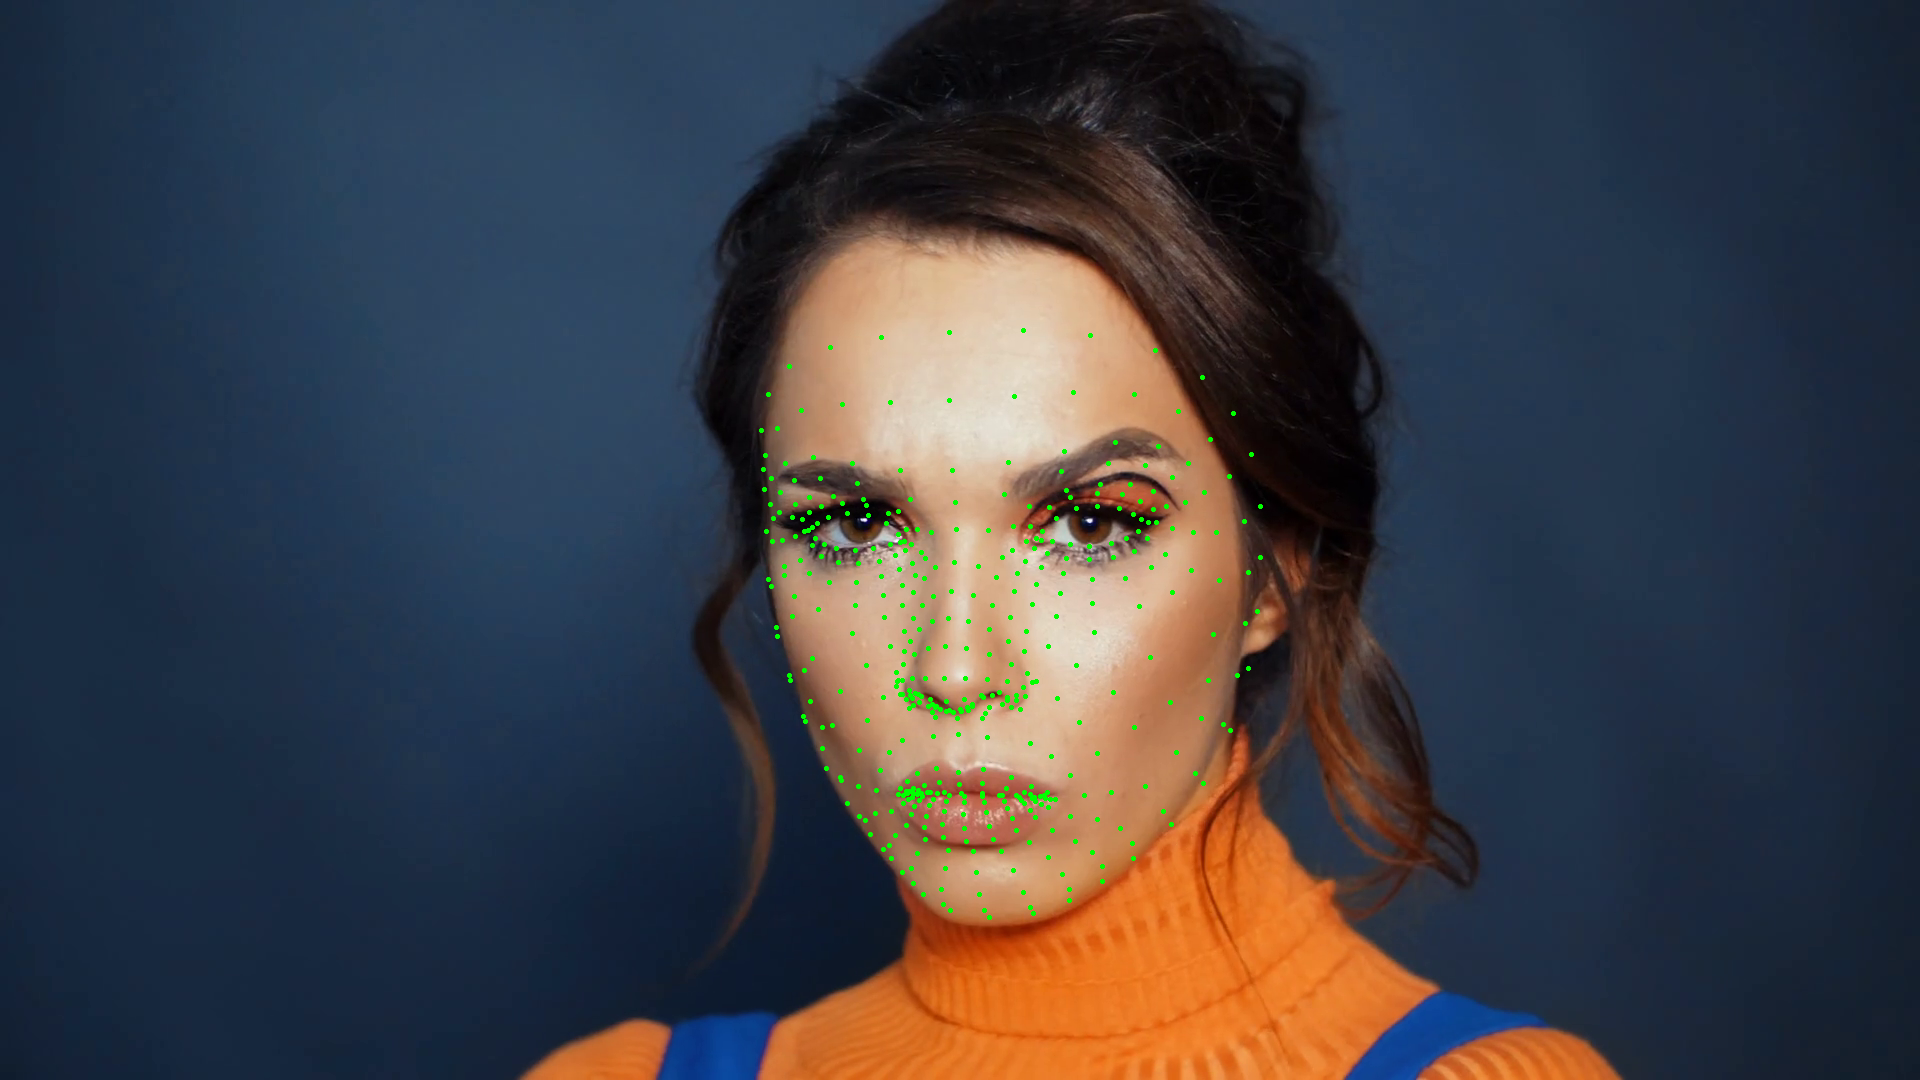

In [6]:
landmarks_of_current_img=[]
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/videoblocks-portrait-of-beautiful-girl-with-negative-emotions-young-woman-with-displeased-face-beautiful-girl-with-painted-eyelashes-frowning-female-face-expression-in-slow-motion-human-emotions-on-face_bwta18axr_thumbnail-1080_01.png')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        # print lips landmark 
        # LIPS_INDEXES = list(set(itertools.chain(*faceModule.FACEMESH_LIPS)))
        # for LIPS_INDEXE in LIPS_INDEXES[:2]:
        #   print(face.landmark[LIPS_INDEXE])

          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              landmarks_of_current_img.append(relative_x)
              landmarks_of_current_img.append(relative_y)
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [7]:
len(landmarks_of_current_img)

936

In [ ]:
landmarks_of_current_img[11]

646

In [8]:
landmarks_to_pred = pd.DataFrame(landmarks_of_current_img).T

In [ ]:
#landmarks_to_pred.iloc[:,::2]

In [9]:
#landmarks_of_current_img= scaler.transform(np.array(landmarks_of_current_img,dtype=np.float32).reshape(1, -1))
landmarks_to_pred.iloc[:,::2]=landmarks_to_pred.iloc[:,::2].sub(landmarks_to_pred.iloc[:,10],axis=0)
landmarks_to_pred.iloc[:,1::2]=landmarks_to_pred.iloc[:,1::2].sub(landmarks_to_pred.iloc[:,11],axis=0)

In [10]:
landmarks_to_pred.shape

(1, 936)

In [11]:
# load models

model_yaw = pickle.load(open('svm_reg_yaw_model.pkl', 'rb'))
model_pitch = pickle.load(open('svm_reg_pitch.pkl', 'rb'))
model_roll = pickle.load(open('svm_reg_roll.pkl', 'rb'))

In [12]:
yaw= model_yaw.predict(landmarks_to_pred)
pitch= model_pitch.predict(landmarks_to_pred)
roll= model_roll.predict(landmarks_to_pred)

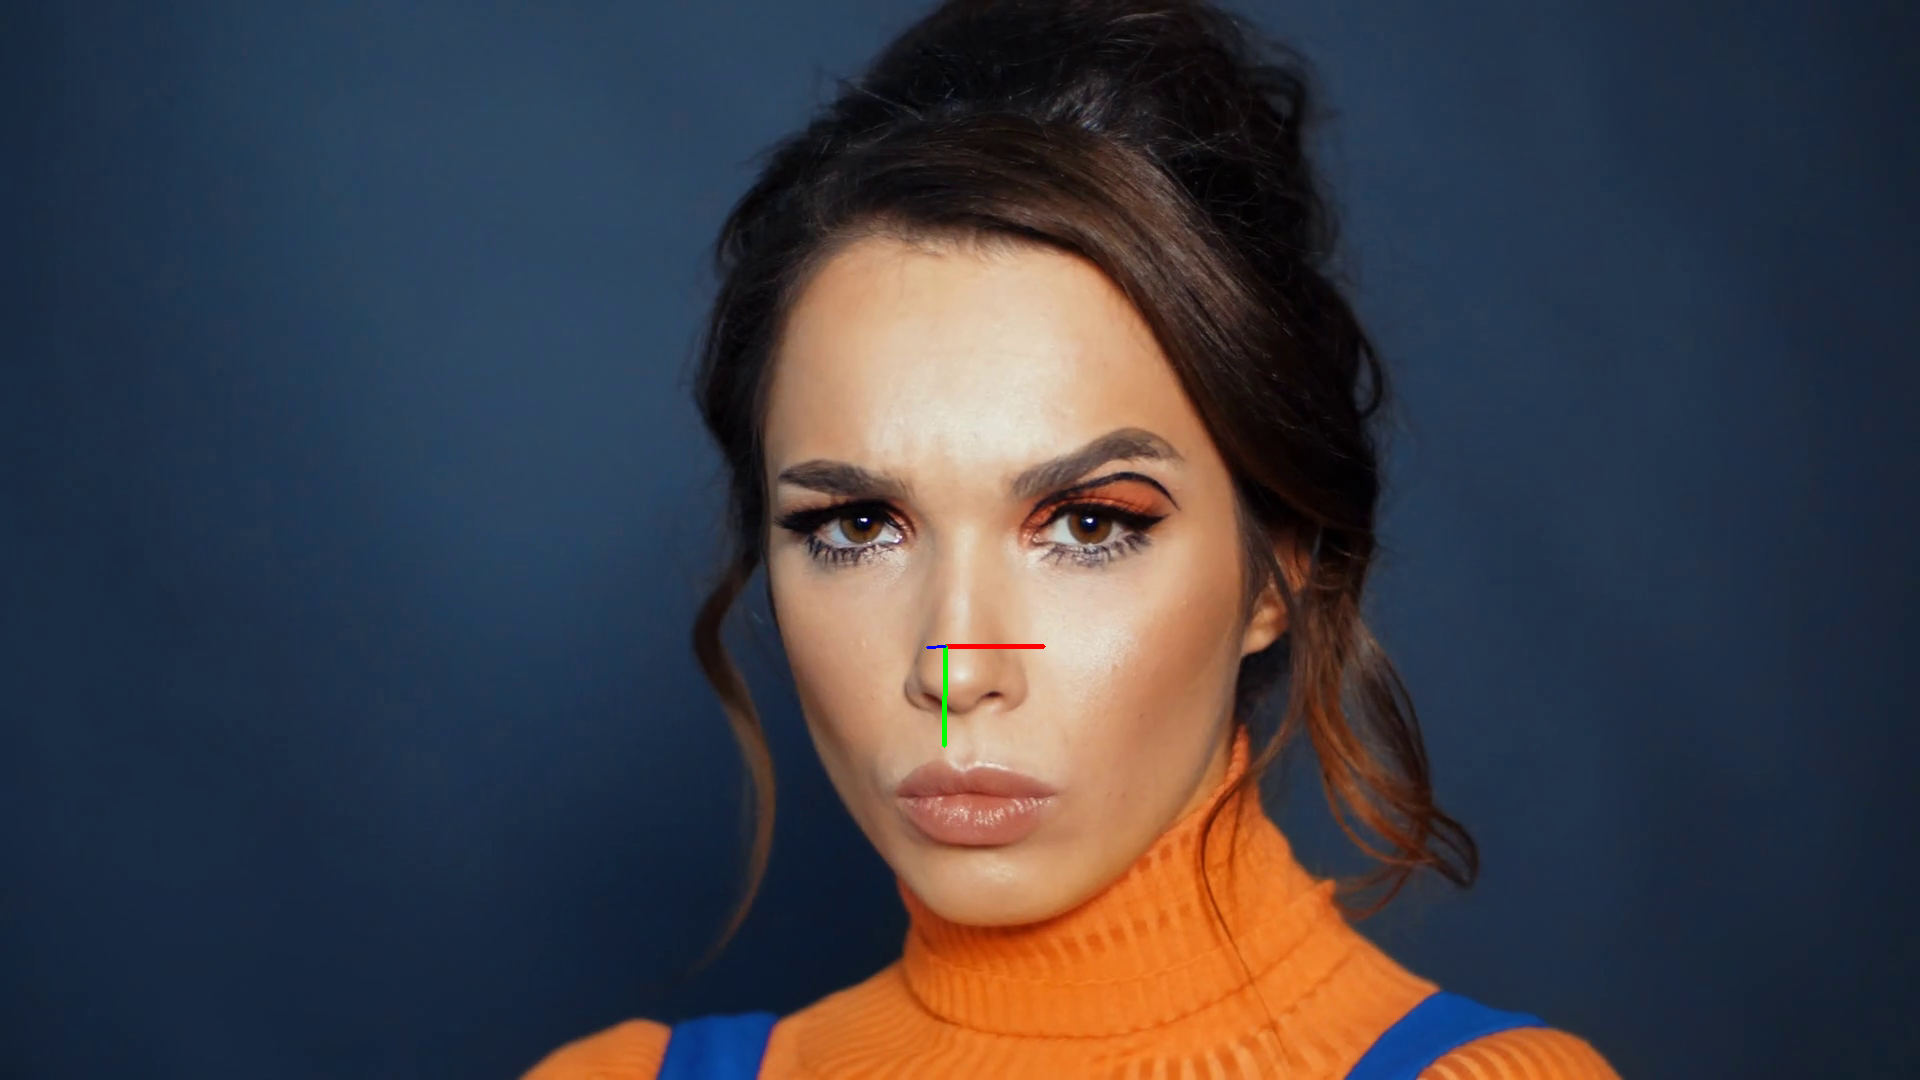

In [13]:
def draw_axis(img, pitch,yaw,roll,tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx 
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img
image = cv2.imread('/content/videoblocks-portrait-of-beautiful-girl-with-negative-emotions-young-woman-with-displeased-face-beautiful-girl-with-painted-eyelashes-frowning-female-face-expression-in-slow-motion-human-emotions-on-face_bwta18axr_thumbnail-1080_01.png')
shape = image.shape
cv2_imshow(draw_axis(image,pitch,yaw,roll,945, 646))

### Vido Demo

In [14]:
!wget https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/GtuAR0I/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4

--2022-06-17 10:15:48--  https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/GtuAR0I/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4
Resolving dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)... 18.160.201.92, 18.160.201.69, 18.160.201.107, ...
Connecting to dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)|18.160.201.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 509917 (498K) [video/mp4]
Saving to: ‘videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4’

videoblocks-portrai 100%[===================>] 497.97K  --.-KB/s    in 0.04s   

2022-06-17 10:15:48 (11.0 MB/s) - ‘videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e24

In [15]:
v_path='/content/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4'
cap=cv2.VideoCapture(v_path)
fourcc=int(cap.get(cv2.CAP_PROP_FOURCC))

FPS=int(cap.get(cv2.CAP_PROP_FPS))
print(FPS)
draw = mediapipe.solutions.drawing_utils

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)

faceModule = mediapipe.solutions.face_mesh
faces = faceModule.FaceMesh(static_image_mode=False)

#result = cv2.VideoWriter("/content/drive/MyDrive/1colab/ML1/2.avi", cv2.VideoWriter_fourcc('X','V','I','D'), FPS, size)
result = cv2.VideoWriter("/content/wrapper.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, size)

success, img = cap.read()
while (cap.isOpened()and success ): 
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = faces.process(imgRGB)
    if results.multi_face_landmarks !=None:
      landmarks_of_current_img=[]

      landmarks=results.multi_face_landmarks[0]
      for landmark in landmarks.landmark:
          x = landmark.x
          y = landmark.y
      
          relative_x = int(img.shape[1] * x)
          relative_y = int(img.shape[0] * y)
          landmarks_of_current_img.append(relative_x)
          landmarks_of_current_img.append(relative_y)
      
      dx=landmarks_of_current_img[10]
      dy=landmarks_of_current_img[11]
      landmarks_to_pred_current = pd.DataFrame(landmarks_of_current_img).T
      landmarks_to_pred_current.iloc[:,::2]=landmarks_to_pred_current.iloc[:,::2].sub(landmarks_to_pred_current.iloc[:,10],axis=0)
      landmarks_to_pred_current.iloc[:,1::2]=landmarks_to_pred_current.iloc[:,1::2].sub(landmarks_to_pred_current.iloc[:,11],axis=0)
      yaw_current= model_yaw.predict(landmarks_to_pred_current)
      pitch_current= model_pitch.predict(landmarks_to_pred_current)
      roll_current= model_roll.predict(landmarks_to_pred_current)


      image4=draw_axis(img,pitch_current,yaw_current,roll_current,dx,dy)
      print(True)

        # draw.draw_landmarks(
        #   img,results.multi_face_landmarks[0])

    #cv2_imshow(img)
    result.write(image4)
    #cv2.waitKey(1)
    success, img = cap.read()
cap.release()
result.release()
cv2.destroyAllWindows()

25
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

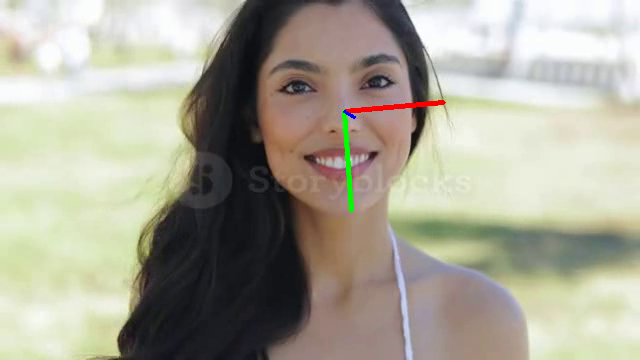

In [ ]:

from IPython.display import clear_output, Image
import base64

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

video_capture = cv2.VideoCapture('/content/wrapper.mp4')
while video_capture.isOpened():
    success, frame = video_capture.read()

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break